In [2]:
!pip install folium
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install matplotlib

  Using cached folium-0.12.1.post1-py2.py3-none-any.whl (95 kB)
  Using cached branca-0.5.0-py3-none-any.whl (24 kB)
  Using cached numpy-1.23.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
  Using cached matplotlib-3.5.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached pandas-1.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached Pillow-9.2.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.2 MB)
  Using cached fonttools-4.37.1-py3-none-any.whl (957 kB)


In [3]:
import folium
from folium import plugins
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from datetime import datetime, timedelta

In [4]:
!pip install pyarrow

  Using cached pyarrow-9.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.3 MB)


In [5]:
data1 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_1_10.parquet")
data2 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_11_20.parquet")
data3 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_jan_21_31.parquet")
data4 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_1_10.parquet")
data5 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_11_20.parquet")
data6 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_feb_21_28.parquet")
data7 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_mar_1_10.parquet")
data8 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_mar_11_20.parquet")
bin_data = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/swm-data/varanasi_swm_bin.parquet")
data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8],ignore_index=True)


In [6]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)
print(bin_data.shape)
bin_data = bin_data.drop_duplicates()
print(bin_data.shape)

(2361320, 12)
(2227945, 12)
(816, 11)
(766, 11)


In [7]:
data['latitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[1][:-1].strip()))
data['longitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[0][1:].strip()))

bin_data['latitude']=bin_data['location.coordinates'].apply(lambda x:float(x.split(",")[1][:-1].strip()))
bin_data['longitude']=bin_data['location.coordinates'].apply(lambda x:float(x.split(",")[0][1:].strip()))

In [8]:
data.drop(["location.coordinates", "location.type","id"], axis=1, inplace=True)

# Since all bins have same capacity, colour category and fullness threshold.
bin_data.drop(["binCapacity", "id","binColor","binCategory", "binFullnessThreshold", "location.type", "location.coordinates"], axis=1, inplace=True)

In [9]:
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_convert("Asia/Kolkata"))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S%z'))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_localize(None))

In [10]:
data = data[data["latitude"]<=26]
data.reset_index(inplace=True)

In [11]:
waste_plants=[[25.213789146665633, 82.91745097600183],[25.331563634401093, 83.02579848934623],[25.297003584155515, 82.99738447902403],[25.356156703687436, 83.00756581280409],[25.35964766301118, 83.03934415423672],
[25.34766174536173, 83.00661942755295]]

In [12]:
!pip install h3

  Using cached h3-3.7.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


In [13]:
import h3

In [14]:
data_update=data[(data['vehicleType']!= 'Refused Compactor')]

In [15]:
temp=[]
for i in range(0,len(data_update)):
    temp.append(h3.geo_to_h3(data_update['latitude'].iloc[i], data_update['longitude'].iloc[i], resolution=8)) 
#data['h3_ids']=temp
data_update['h3_ids_8']=temp

/tmp/ipykernel_24/2151225121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_update['h3_ids_8']=temp


In [16]:
temp=[]
for i in np.unique(data_update['h3_ids_8']):
    data_2=data_update[(data_update['h3_ids_8']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp.append([i,num])
temp=pd.DataFrame(temp,columns=['h3_ids_8','no_of_different_vehicles'])

In [17]:
temp=temp.sort_values(by=['no_of_different_vehicles'],ascending=False)

In [18]:
temp

,h3_ids_8,no_of_different_vehicles
207,883c164567fffff,104
205,883c164563fffff,102
172,883c16450dfffff,96
170,883c164509fffff,92
209,883c16456bfffff,87
...,...,...
242,883c1646abfffff,1
243,883c1646adfffff,1
246,883c1646e5fffff,1
289,883c164811fffff,1


In [19]:
res_9=[]
temp_21=data_update[(data_update['h3_ids_8']==temp.iloc[0]['h3_ids_8'])]
for i in range(0,len(temp_21)):
    res_9.append(h3.geo_to_h3(temp_21['latitude'].iloc[i], temp_21['longitude'].iloc[i], resolution=9)) 
temp_21['h3_ids_9']=res_9

/tmp/ipykernel_24/1067490315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_21['h3_ids_9']=res_9


In [20]:
res_9=[]
temp_22=data_update[(data_update['h3_ids_8']==temp.iloc[1]['h3_ids_8'])]
for i in range(0,len(temp_22)):
    res_9.append(h3.geo_to_h3(temp_22['latitude'].iloc[i], temp_22['longitude'].iloc[i], resolution=9)) 
temp_22['h3_ids_9']=res_9

/tmp/ipykernel_24/284065860.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_22['h3_ids_9']=res_9


In [21]:
res_9=[]
temp_23=data_update[(data_update['h3_ids_8']==temp.iloc[2]['h3_ids_8'])]
for i in range(0,len(temp_23)):
    res_9.append(h3.geo_to_h3(temp_23['latitude'].iloc[i], temp_23['longitude'].iloc[i], resolution=9)) 
temp_23['h3_ids_9']=res_9

res_9=[]
temp_24=data_update[(data_update['h3_ids_8']==temp.iloc[3]['h3_ids_8'])]
for i in range(0,len(temp_24)):
    res_9.append(h3.geo_to_h3(temp_24['latitude'].iloc[i], temp_24['longitude'].iloc[i], resolution=9)) 
temp_24['h3_ids_9']=res_9

res_9=[]
temp_25=data_update[(data_update['h3_ids_8']==temp.iloc[4]['h3_ids_8'])]
for i in range(0,len(temp_25)):
    res_9.append(h3.geo_to_h3(temp_25['latitude'].iloc[i], temp_25['longitude'].iloc[i], resolution=9)) 
temp_25['h3_ids_9']=res_9



/tmp/ipykernel_24/1612497649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_23['h3_ids_9']=res_9
/tmp/ipykernel_24/1612497649.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_24['h3_ids_9']=res_9
/tmp/ipykernel_24/1612497649.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [22]:
temp1=[]
for i in np.unique(temp_21['h3_ids_9']):
    data_2=temp_21[(temp_21['h3_ids_9']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp1.append([i,num])
temp1=pd.DataFrame(temp1,columns=['h3_ids_9','no_of_different_vehicles'])

temp2=[]
for i in np.unique(temp_22['h3_ids_9']):
    data_2=temp_22[(temp_22['h3_ids_9']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp2.append([i,num])
temp2=pd.DataFrame(temp2,columns=['h3_ids_9','no_of_different_vehicles'])

temp3=[]
for i in np.unique(temp_23['h3_ids_9']):
    data_2=temp_23[(temp_23['h3_ids_9']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp3.append([i,num])
temp3=pd.DataFrame(temp3,columns=['h3_ids_9','no_of_different_vehicles'])

temp4=[]
for i in np.unique(temp_24['h3_ids_9']):
    data_2=temp_24[(temp_24['h3_ids_9']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp4.append([i,num])
temp4=pd.DataFrame(temp4,columns=['h3_ids_9','no_of_different_vehicles'])

temp5=[]
for i in np.unique(temp_25['h3_ids_9']):
    data_2=temp_25[(temp_25['h3_ids_9']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp5.append([i,num])
temp5=pd.DataFrame(temp5,columns=['h3_ids_9','no_of_different_vehicles'])


In [23]:
temp1=temp1.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp2=temp2.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp3=temp3.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp4=temp4.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp5=temp5.sort_values(by=['no_of_different_vehicles'],ascending=False)

In [24]:
temp4

,h3_ids_9,no_of_different_vehicles
6,893c164509bffff,90
4,893c1645093ffff,67
0,893c1645083ffff,62
2,893c164508bffff,62
1,893c1645087ffff,52
8,893c16450d7ffff,49
3,893c164508fffff,47
10,893c164554bffff,6
9,893c1645467ffff,5
7,893c16450bbffff,4


In [25]:
temp5

,h3_ids_9,no_of_different_vehicles
8,893c16456afffff,79
7,893c16456abffff,66
4,893c1645633ffff,65
6,893c16456a7ffff,60
10,893c16456b7ffff,31
1,893c164544fffff,26
9,893c16456b3ffff,15
5,893c16456a3ffff,14
3,893c1645617ffff,6
0,893c16450dbffff,2


In [26]:
res_10=[]
temp_2=temp_21[(temp_21['h3_ids_9']==temp1.iloc[0]['h3_ids_9'])]
for i in range(0,len(temp_2)):
    res_10.append(h3.geo_to_h3(temp_2['latitude'].iloc[i], temp_2['longitude'].iloc[i], resolution=10)) 
temp_2['h3_ids_10']=res_10

res_10=[]
temp_3=temp_22[(temp_22['h3_ids_9']==temp2.iloc[0]['h3_ids_9'])]
for i in range(0,len(temp_3)):
    res_10.append(h3.geo_to_h3(temp_3['latitude'].iloc[i], temp_3['longitude'].iloc[i], resolution=10)) 
temp_3['h3_ids_10']=res_10

res_10=[]
temp_4=temp_23[(temp_23['h3_ids_9']==temp3.iloc[0]['h3_ids_9'])]
for i in range(0,len(temp_4)):
    res_10.append(h3.geo_to_h3(temp_4['latitude'].iloc[i], temp_4['longitude'].iloc[i], resolution=10)) 
temp_4['h3_ids_10']=res_10

res_10=[]
temp_5=temp_24[(temp_24['h3_ids_9']==temp4.iloc[0]['h3_ids_9'])]
for i in range(0,len(temp_5)):
    res_10.append(h3.geo_to_h3(temp_5['latitude'].iloc[i], temp_5['longitude'].iloc[i], resolution=10)) 
temp_5['h3_ids_10']=res_10

res_10=[]
temp_6=temp_25[(temp_25['h3_ids_9']==temp5.iloc[0]['h3_ids_9'])]
for i in range(0,len(temp_6)):
    res_10.append(h3.geo_to_h3(temp_6['latitude'].iloc[i], temp_6['longitude'].iloc[i], resolution=10)) 
temp_6['h3_ids_10']=res_10

/tmp/ipykernel_24/859914948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_2['h3_ids_10']=res_10
/tmp/ipykernel_24/859914948.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_3['h3_ids_10']=res_10
/tmp/ipykernel_24/859914948.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [27]:
temp1=[]
for i in np.unique(temp_2['h3_ids_10']):
    data_2=temp_2[(temp_2['h3_ids_10']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp1.append([i,num])
temp1=pd.DataFrame(temp1,columns=['h3_ids_10','no_of_different_vehicles'])

temp2=[]
for i in np.unique(temp_3['h3_ids_10']):
    data_2=temp_3[(temp_3['h3_ids_10']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp2.append([i,num])
temp2=pd.DataFrame(temp2,columns=['h3_ids_10','no_of_different_vehicles'])

temp3=[]
for i in np.unique(temp_4['h3_ids_10']):
    data_2=temp_4[(temp_4['h3_ids_10']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp3.append([i,num])
temp3=pd.DataFrame(temp3,columns=['h3_ids_10','no_of_different_vehicles'])

temp4=[]
for i in np.unique(temp_5['h3_ids_10']):
    data_2=temp_5[(temp_5['h3_ids_10']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp4.append([i,num])
temp4=pd.DataFrame(temp4,columns=['h3_ids_10','no_of_different_vehicles'])

temp5=[]
for i in np.unique(temp_6['h3_ids_10']):
    data_2=temp_6[(temp_6['h3_ids_10']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp5.append([i,num])
temp5=pd.DataFrame(temp5,columns=['h3_ids_10','no_of_different_vehicles'])


In [28]:
temp1=temp1.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp2=temp2.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp3=temp3.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp4=temp4.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp5=temp5.sort_values(by=['no_of_different_vehicles'],ascending=False)

In [29]:
res_11=[]
temp_211=temp_2[(temp_2['h3_ids_10']==temp1.iloc[0]['h3_ids_10'])]
for i in range(0,len(temp_211)):
    res_11.append(h3.geo_to_h3(temp_211['latitude'].iloc[i], temp_211['longitude'].iloc[i], resolution=11)) 
temp_211['h3_ids_11']=res_11

res_11=[]
temp_311=temp_3[(temp_3['h3_ids_10']==temp2.iloc[0]['h3_ids_10'])]
for i in range(0,len(temp_311)):
    res_11.append(h3.geo_to_h3(temp_311['latitude'].iloc[i], temp_311['longitude'].iloc[i], resolution=11)) 
temp_311['h3_ids_11']=res_11

res_11=[]
temp_411=temp_4[(temp_4['h3_ids_10']==temp3.iloc[0]['h3_ids_10'])]
for i in range(0,len(temp_411)):
    res_11.append(h3.geo_to_h3(temp_411['latitude'].iloc[i], temp_411['longitude'].iloc[i], resolution=11)) 
temp_411['h3_ids_11']=res_11

res_11=[]
temp_511=temp_5[(temp_5['h3_ids_10']==temp4.iloc[0]['h3_ids_10'])]
for i in range(0,len(temp_511)):
    res_11.append(h3.geo_to_h3(temp_511['latitude'].iloc[i], temp_511['longitude'].iloc[i], resolution=11)) 
temp_511['h3_ids_11']=res_11

res_11=[]
temp_611=temp_6[(temp_6['h3_ids_10']==temp5.iloc[0]['h3_ids_10'])]
for i in range(0,len(temp_611)):
    res_11.append(h3.geo_to_h3(temp_611['latitude'].iloc[i], temp_611['longitude'].iloc[i], resolution=11)) 
temp_611['h3_ids_11']=res_11

/tmp/ipykernel_24/4278212210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_211['h3_ids_11']=res_11
/tmp/ipykernel_24/4278212210.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_311['h3_ids_11']=res_11
/tmp/ipykernel_24/4278212210.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [30]:
#res_11=[]
#temp_4=temp_3[(temp_3['h3_ids_10']==temp.iloc[0]['h3_ids_10'])]
#for i in range(0,len(temp_4)):
#    res_11.append(h3.geo_to_h3(temp_4['latitude'].iloc[i], temp_4['longitude'].iloc[i], resolution=11)) 
#temp_4['h3_ids_11']=res_11
#temp_4

In [31]:
temp1=[]
for i in np.unique(temp_211['h3_ids_11']):
    data_2=temp_211[(temp_211['h3_ids_11']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp1.append([i,num])
temp1=pd.DataFrame(temp1,columns=['h3_ids_11','no_of_different_vehicles'])


temp2=[]
for i in np.unique(temp_311['h3_ids_11']):
    data_2=temp_311[(temp_311['h3_ids_11']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp2.append([i,num])
temp2=pd.DataFrame(temp2,columns=['h3_ids_11','no_of_different_vehicles'])

temp3=[]
for i in np.unique(temp_411['h3_ids_11']):
    data_2=temp_411[(temp_411['h3_ids_11']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp3.append([i,num])
temp3=pd.DataFrame(temp3,columns=['h3_ids_11','no_of_different_vehicles'])

temp4=[]
for i in np.unique(temp_511['h3_ids_11']):
    data_2=temp_511[(temp_511['h3_ids_11']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp4.append([i,num])
temp4=pd.DataFrame(temp4,columns=['h3_ids_11','no_of_different_vehicles'])

temp5=[]
for i in np.unique(temp_611['h3_ids_11']):
    data_2=temp_611[(temp_611['h3_ids_11']==i)]
    num=len(np.unique(data_2['license_plate']))
    temp5.append([i,num])
temp5=pd.DataFrame(temp5,columns=['h3_ids_11','no_of_different_vehicles'])

temp1=temp1.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp2=temp2.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp3=temp3.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp4=temp4.sort_values(by=['no_of_different_vehicles'],ascending=False)
temp5=temp5.sort_values(by=['no_of_different_vehicles'],ascending=False)


In [32]:
temp4.iloc[0]

h3_ids_11                   8b3c16450995fff
no_of_different_vehicles                 76
Name: 6, dtype: object

In [33]:
map2=folium.Map(zoom_start=12)
mp=h3.h3_set_to_multi_polygon([temp1.iloc[0]['h3_ids_11']], geo_json=True)
h3s={"type": "Feature",
"properties":{},
"geometry": {"type": "MultiPolygon",
"coordinates": mp}}
g=folium.GeoJson(h3s,style_function=lambda x: {'fillColor': 'white','color':'black'})
g.add_to(map2)

mp=h3.h3_set_to_multi_polygon([temp2.iloc[0]['h3_ids_11']], geo_json=True)
h3s={"type": "Feature",
"properties":{},
"geometry": {"type": "MultiPolygon",
"coordinates": mp}}
g=folium.GeoJson(h3s,style_function=lambda x: {'fillColor': 'white','color':'black'})
g.add_to(map2)

mp=h3.h3_set_to_multi_polygon([temp3.iloc[0]['h3_ids_11']], geo_json=True)
h3s={"type": "Feature",
"properties":{},
"geometry": {"type": "MultiPolygon",
"coordinates": mp}}
g=folium.GeoJson(h3s,style_function=lambda x: {'fillColor': 'white','color':'black'})
g.add_to(map2)

mp=h3.h3_set_to_multi_polygon([temp4.iloc[0]['h3_ids_11']], geo_json=True)
h3s={"type": "Feature",
"properties":{},
"geometry": {"type": "MultiPolygon",
"coordinates": mp}}
g=folium.GeoJson(h3s,style_function=lambda x: {'fillColor': 'white','color':'black'})
g.add_to(map2)

mp=h3.h3_set_to_multi_polygon([temp5.iloc[0]['h3_ids_11']], geo_json=True)
h3s={"type": "Feature",
"properties":{},
"geometry": {"type": "MultiPolygon",
"coordinates": mp}}
g=folium.GeoJson(h3s,style_function=lambda x: {'fillColor': 'white','color':'black'})
g.add_to(map2)
map2.fit_bounds(map2.get_bounds())
map2

In [34]:
tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(map2)
map2

In [35]:
map2.save('5amongtop5hexesin_res8.html')

In [36]:
temp=[temp1.iloc[0]['h3_ids_11'],temp2.iloc[0]['h3_ids_11'],temp3.iloc[0]['h3_ids_11'],temp4.iloc[0]['h3_ids_11'],temp5.iloc[0]['h3_ids_11']]
temp

['8b3c16456640fff',
 '8b3c16456290fff',
 '8b3c16450d1dfff',
 '8b3c16450995fff',
 '8b3c16456ae0fff']

In [37]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [38]:
temp1=[]
for i in range(0,len(data_update)):
    temp1.append(h3.geo_to_h3(data_update['latitude'].iloc[i], data_update['longitude'].iloc[i], resolution=11)) 
#data['h3_ids']=temp
data_update['h3_ids_11']=temp1

/tmp/ipykernel_24/1362170774.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_update['h3_ids_11']=temp1


In [38]:
'''
This has been executed once and the result is converted into csv file
influx_11=[]
start_date = date(2022,3,1)
end_date = date(2022, 3, 30)
for i in temp:
  print(i)
  q=h3.k_ring(i, 1)
  q.remove(i)
  for single_date in daterange(start_date, end_date):
            count=0
            for license_plate in np.unique(data_update.license_plate):
              data_single_vehicle=data_update[ (data_update['license_plate']==license_plate) & (data_update["observationDateTime"]>= str(single_date)+" 00:00:00") & (data_update["observationDateTime"]<= str(single_date)+" 23:59:59")] 
              for k in range(0,len(data_single_vehicle)-1):
                    if ((data_single_vehicle['h3_ids_11'].iloc[k] in q ) & (data_single_vehicle['h3_ids_11'].iloc[k+1]== i)) :
                        count+=1
            influx_11.append([count,i,single_date])
'''

8b3c16456640fff
8b3c16456290fff
8b3c16450d1dfff
8b3c16450995fff
8b3c16456ae0fff


In [40]:
'''
influx_11=pd.DataFrame(influx_11,columns=['count','main_id','date'])
influx_11.to_csv('influx_11.csv')
'''

In [42]:
influx_11=pd.read_csv('influx_11.csv')
influx_11

,Unnamed: 0,count,main_id,date
0,0,1,8b3c16456640fff,2022-03-01
1,1,5,8b3c16456640fff,2022-03-02
2,2,1,8b3c16456640fff,2022-03-03
3,3,0,8b3c16456640fff,2022-03-04
4,4,4,8b3c16456640fff,2022-03-05
...,...,...,...,...
140,140,0,8b3c16456ae0fff,2022-03-25
141,141,0,8b3c16456ae0fff,2022-03-26
142,142,0,8b3c16456ae0fff,2022-03-27
143,143,0,8b3c16456ae0fff,2022-03-28


In [67]:
x1=influx_11[(influx_11['main_id']=='8b3c16456ae0fff')]['date'].reset_index(drop=True)
y1=influx_11[(influx_11['main_id']=='8b3c16456ae0fff')]['count'].reset_index(drop=True)
y2=influx_11[(influx_11['main_id']=='8b3c16450995fff')]['count'].reset_index(drop=True)
y3=influx_11[(influx_11['main_id']=='8b3c16450d1dfff')]['count'].reset_index(drop=True)
y4=influx_11[(influx_11['main_id']=='8b3c16456290fff')]['count'].reset_index(drop=True)
y5=influx_11[(influx_11['main_id']=='8b3c16456640fff')]['count'].reset_index(drop=True)

In [76]:
import calendar
x2=[]
start_date = date(2022,3,1)
end_date = date(2022, 3, 30)
for i in daterange(start_date, end_date):
    x2.append(str(calendar.day_name[i.weekday()])+' '+str(i))

In [77]:
x2

['Tuesday 2022-03-01',
 'Wednesday 2022-03-02',
 'Thursday 2022-03-03',
 'Friday 2022-03-04',
 'Saturday 2022-03-05',
 'Sunday 2022-03-06',
 'Monday 2022-03-07',
 'Tuesday 2022-03-08',
 'Wednesday 2022-03-09',
 'Thursday 2022-03-10',
 'Friday 2022-03-11',
 'Saturday 2022-03-12',
 'Sunday 2022-03-13',
 'Monday 2022-03-14',
 'Tuesday 2022-03-15',
 'Wednesday 2022-03-16',
 'Thursday 2022-03-17',
 'Friday 2022-03-18',
 'Saturday 2022-03-19',
 'Sunday 2022-03-20',
 'Monday 2022-03-21',
 'Tuesday 2022-03-22',
 'Wednesday 2022-03-23',
 'Thursday 2022-03-24',
 'Friday 2022-03-25',
 'Saturday 2022-03-26',
 'Sunday 2022-03-27',
 'Monday 2022-03-28',
 'Tuesday 2022-03-29']

Text(0, 0.5, 'Count on each hexid on daily basis')

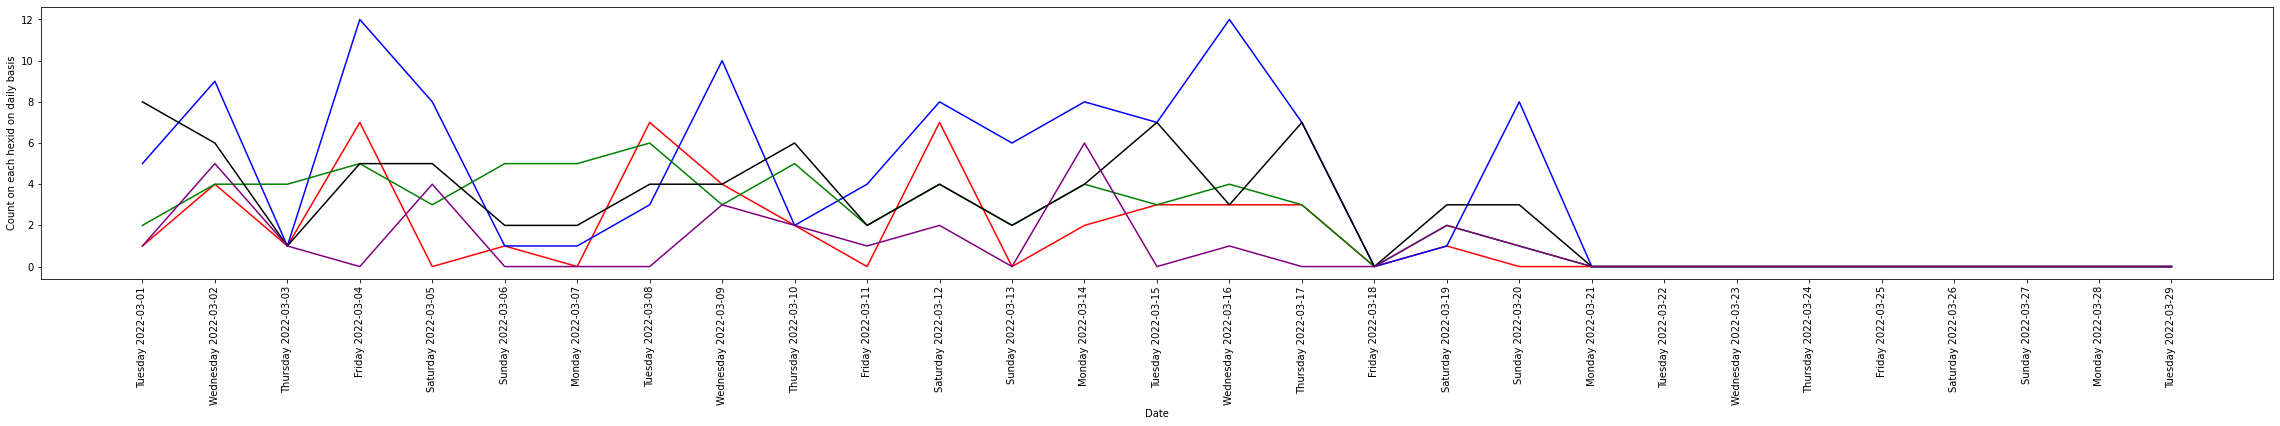

In [80]:
plt.figure(figsize=(40, 5))
plt.xticks(rotation=90)
plt.plot(x2,y1,color='red')
plt.plot(x2,y2,color='blue')
plt.plot(x2,y3,color='green')
plt.plot(x2,y4,color='black')
plt.plot(x2,y5,color='purple')
plt.xlabel('Date')
plt.ylabel('Count on each hexid on daily basis')